In [1]:
from tasks import preprocessing, util

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import os

2024-02-17 13:34:26.382044: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 13:34:26.382132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 13:34:26.385891: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-17 13:34:26.401560: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-17 13:34:28.573590: W tensorflow/compiler/tf2

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

INPUT_DIR = "input"
OUTPUT_DIR = "output"
INTERMEDIATE_DIR = "intermediate"

## Dataset

Acquiring and preprocessing our data with the goal of eventually acquiring a sufficient representation of our text is the most difficult and time-consuming task. We thus split it in distinct phases:

* Original dataset acquisition and parsing
* Qualitative analysis and preprocessing
* Transformation for the NLP task

Note that due to the relative custom code complexity, most of the code used in this section was developed and imported from python source files located in the `tasks` module. In-depth documentation and implementation details can be found in these files. 

In [3]:
print("Loading training dataset...")
train_df = preprocessing.conllu_to_pd("input/UD_English-EWT/en_ewt-ud-train.conllu")
print("Loading validation dataset...")
val_df = preprocessing.conllu_to_pd("input/UD_English-EWT/en_ewt-ud-dev.conllu")
print("Loading test dataset...")
test_df = preprocessing.conllu_to_pd("input/UD_English-EWT/en_ewt-ud-test.conllu")

print(f"Training data shape: {train_df.shape}\nValidation data shape: {val_df.shape}"
      "\nTest data shape: {test_df.shape}")

Loading training dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/12544 [00:00<?, ?it/s]

Loading validation dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/2001 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/2001 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/2001 [00:00<?, ?it/s]

Loading test dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/2077 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/2077 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/2077 [00:00<?, ?it/s]

Training data shape: (207227, 3)
Validation data shape: (25511, 3)
Test data shape: {test_df.shape}


Below we can see a preview of our parsed training dataset. Our preprocessing exploits pandas's ordering scheme in order to make sure the words are inserted in the order they appear in the sentence. This ordering will prove important later.

In [4]:
train_df

,words,pos,sent_id
0,al,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
1,-,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
2,zaman,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
3,:,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
4,american,ADJ,weblog-juancole.com_juancole_20051126063000_EN...
...,...,...,...
207222,on,ADP,reviews-319816-0029
207223,my,PRON,reviews-319816-0029
207224,car,NOUN,reviews-319816-0029
207225,),PUNCT,reviews-319816-0029


As mentioned above, our dataset features words connected with punctuation such as "don't". These are normally treated as two words, with the first being their intuitive POS tag ("do" - AUX) and the second as part of the first ("n't" - PART).

This dataset contains both the full words and their split versions, with only the latter featuring valid POS tags. The former are instead marked by a pseudo-tag (here "_").

In [5]:
invalid_idx = train_df.pos == "_"
train_df[invalid_idx]

,words,pos,sent_id
176,don't,_,weblog-juancole.com_juancole_20051126063000_EN...
704,won't,_,weblog-juancole.com_juancole_20051126063000_EN...
868,don't,_,weblog-blogspot.com_healingiraq_20040409053012...
1058,don't,_,weblog-blogspot.com_healingiraq_20040409053012...
1078,doesn't,_,weblog-blogspot.com_healingiraq_20040409053012...
...,...,...,...
207078,couldn't,_,reviews-319816-0025
207091,don't,_,reviews-319816-0025
207096,employees',_,reviews-319816-0025
207164,i'm,_,reviews-319816-0027


In [6]:
" ".join(train_df[invalid_idx].words.unique()[:30])

"don't won't doesn't haven't didn't others it's elena's women's children's i'm people's musharraf's sharon's hamas's right's cannot isn't one's let's reporter's he's that's pakistan's world's bush's military's sharif's can't couldn't"

Below we can see an example of a word being contained both times in the dataset, one in full with the pseudo-tag, and the other as split words with valid POS tags.

In [7]:
train_df.iloc[176:179]

,words,pos,sent_id
176,don't,_,weblog-juancole.com_juancole_20051126063000_EN...
177,do,AUX,weblog-juancole.com_juancole_20051126063000_EN...
178,n't,PART,weblog-juancole.com_juancole_20051126063000_EN...


We thus remove the full words including the pseudo-tag from our datasets, ensuring that all target POS tags will be compliant with the UPOS scheme.

In [8]:
train_df = train_df[~invalid_idx]
val_df = val_df[val_df.pos != "_"]
test_df = test_df[test_df.pos != "_"]

### Qualitative Analysis

We analyze our dataset in two granualities: sentences and individual words. We begin by analyzing how many words are in each sentence, which will give us an idea on the size of context available for each word.

In [9]:
def length_sentences(df: pd.DataFrame) -> float:
    lengths = df.groupby(["sent_id"]).agg(lambda x: len(x))
    return lengths.words


train_length = length_sentences(train_df)
val_length = length_sentences(val_df)
test_length = length_sentences(test_df)

Figured saved to output/ex_2_dataset_stats.png


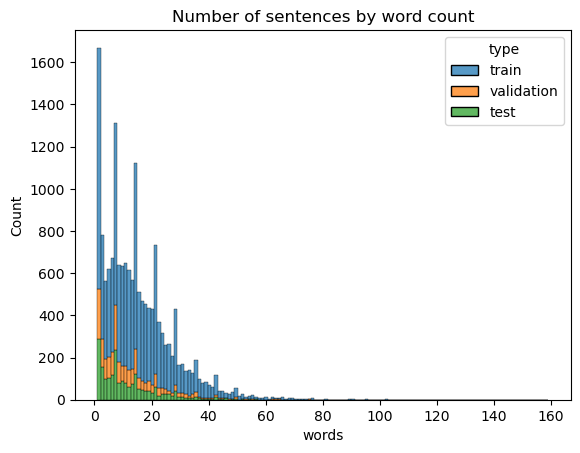

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


stats_df = pd.DataFrame({"words": pd.concat([train_length, val_length, test_length], ignore_index=True),
                        "type": len(train_length)*["train"] +
                         len(val_length)*["validation"] + 
                         len(test_length)*["test"]})

sns.histplot(x="words", 
             hue="type", 
             data=stats_df, 
             multiple="stack")

plt.title("Number of sentences by word count")
util.save_plot("ex_2_dataset_stats.png", OUTPUT_DIR)
plt.show()

In [11]:
train_length.describe()

count    12544.000000
mean        16.311703
std         12.404826
min          1.000000
25%          7.000000
50%         14.000000
75%         23.000000
max        159.000000
Name: words, dtype: float64

In [12]:
val_length.describe()

count    2001.000000
mean       12.569715
std        10.419274
min         1.000000
25%         5.000000
50%        10.000000
75%        17.000000
max        75.000000
Name: words, dtype: float64

In [13]:
test_length.describe()

count    2077.000000
mean       12.082812
std        10.607005
min         1.000000
25%         4.000000
50%         9.000000
75%        17.000000
max        81.000000
Name: words, dtype: float64

In [14]:
vocab_size = len(set(train_df.words))
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 16654


In [15]:
print(f"Total word count:\nTraining: {train_df.shape[0]}"
      f"\nValidation: {val_df.shape[0]}"
      f"\nTesting: {test_df.shape[0]}")

Total word count:
Training: 204614
Validation: 25152
Testing: 25096


In [16]:
print(f"Total sentence count:\nTraining: {len(set(train_df.sent_id))}"
      f"\nValidation: {len(set(val_df.sent_id))}"
      f"\nTesting: {len(set(test_df.sent_id))}")

Total sentence count:
Training: 12544
Validation: 2001
Testing: 2077


## Baseline Model

In [43]:
from tasks.models import BaselineLabelClassifier


x_base_train = train_df.words
x_base_valid = val_df.words
x_base_test = test_df.words

y_base_train = train_df.pos
y_base_valid = val_df.pos
y_base_test = test_df.pos

base_cls = BaselineLabelClassifier()
base_cls.fit(X=x_base_train, y=y_base_train)

BaselineLabelClassifier()

In [18]:
from sklearn.metrics import classification_report


training_preds = base_cls.predict(x_base_train)
print(classification_report(y_base_train, training_preds))

              precision    recall  f1-score   support

         ADJ       0.88      0.89      0.89     13152
         ADP       0.87      0.67      0.76     17795
         ADV       0.61      0.83      0.71     10113
         AUX       0.88      0.79      0.83     12828
       CCONJ       0.98      0.99      0.99      6688
         DET       0.96      0.95      0.95     16299
        INTJ       0.68      0.87      0.76       693
        NOUN       0.88      0.90      0.89     34813
         NUM       0.99      0.89      0.94      4126
        PART       0.71      0.89      0.79      5748
        PRON       0.90      0.95      0.93     18642
       PROPN       0.90      0.84      0.87     12325
       PUNCT       0.99      0.99      0.99     23597
       SCONJ       0.64      0.41      0.50      3839
         SYM       0.88      0.83      0.85       721
        VERB       0.83      0.89      0.86     22594
           X       0.86      0.64      0.74       641

    accuracy              

In [19]:
test_preds = base_cls.predict(x_base_test)
print(classification_report(y_base_test, test_preds))

              precision    recall  f1-score   support

         ADJ       0.88      0.83      0.85      1787
         ADP       0.89      0.67      0.76      2033
         ADV       0.62      0.83      0.71      1178
         AUX       0.89      0.78      0.83      1543
       CCONJ       0.99      0.99      0.99       737
         DET       0.96      0.95      0.95      1897
        INTJ       0.70      0.72      0.71       120
        NOUN       0.66      0.89      0.76      4137
         NUM       0.96      0.54      0.69       542
        PART       0.70      0.90      0.79       649
        PRON       0.91      0.95      0.93      2162
       PROPN       0.88      0.48      0.62      1980
       PUNCT       1.00      0.98      0.99      3096
       SCONJ       0.60      0.44      0.51       384
         SYM       0.81      0.83      0.82       109
        VERB       0.80      0.83      0.81      2606
           X       0.00      0.00      0.00       136

    accuracy              

## MLP Classifier

In [21]:
def exclude_small_sentences(conllu_df: pd.DataFrame, min_len: int) -> pd.DataFrame:
    assert 1 <= min_len

    length_df = length_sentences(conllu_df)
    valid_length_df = length_df[length_df >= min_len]
    valid_ids = set(valid_length_df.index)
    return conllu_df[conllu_df.sent_id.isin(valid_ids)]

In [22]:
MIN_SENTENCE_LENGTH = 5
WINDOW_SIZE = 5
# training data are used exclusively for training accuracy, thus 
# we only need a small, representative sample
TRAINING_LIM = 25000
VALID_LIM = 25000
TEST_LIM = 10000
SEED = 42
PAD_TOKEN = "<PAD>"

In [23]:
train_df_filt = exclude_small_sentences(train_df, MIN_SENTENCE_LENGTH)
val_df_filt = exclude_small_sentences(val_df, MIN_SENTENCE_LENGTH)
test_df_filt = exclude_small_sentences(test_df, MIN_SENTENCE_LENGTH)

train_df_filt

,words,pos,sent_id
0,al,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
1,-,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
2,zaman,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
3,:,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
4,american,ADJ,weblog-juancole.com_juancole_20051126063000_EN...
...,...,...,...
207222,on,ADP,reviews-319816-0029
207223,my,PRON,reviews-319816-0029
207224,car,NOUN,reviews-319816-0029
207225,),PUNCT,reviews-319816-0029


In [24]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, Embedding, TextVectorization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import LabelBinarizer

In [25]:
# download and unzip only if the download and unzipped files do not exist 
!wget -nc -P input/fasttext https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

![ -f "input/fasttext/cc.en.300.bin" ] && echo "Skipping model file" || gzip --decompress --keep --force "input/fasttext/cc.en.300.bin.gz"   

File ‘input/fasttext/cc.en.300.bin.gz’ already there; not retrieving.

Skipping model file


In [26]:
import fasttext 


print("Loading embedding model...")
fasttext_model = fasttext.load_model('input/fasttext/cc.en.300.bin')

Loading embedding model...


In [27]:
(
    x_train_mlp,
    x_valid_mlp,
    x_test_mlp,
    y_train_mlp,
    y_valid_mlp,
    y_test_mlp,
    lb_mlp,
) = preprocessing.mlp_input(
    train_df_filt,
    val_df_filt,
    test_df_filt,
    embed_model=fasttext_model,
    intermediate_dir=INTERMEDIATE_DIR,
    train_lim=TRAINING_LIM,
    val_lim=VALID_LIM,
    test_lim=TEST_LIM,
    window_size=WINDOW_SIZE,
    seed=SEED,
    pad_token=PAD_TOKEN,
)

Attempting to load intermediate calculations...
Loaded cached calculations.


In [28]:
mlp = keras.saving.load_model(os.path.join(INPUT_DIR, "model.keras"))


print(classification_report(y_train_mlp, mlp.predict(x_train_mlp)))

2024-02-17 13:35:31.005467: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-17 13:35:31.376630: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-17 13:35:31.377051: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

782/782 [==============================] - 4s 3ms/step


2024-02-17 13:35:40.623577: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 144030000 exceeds 10% of free system memory.
2024-02-17 13:35:41.011846: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 144030000 exceeds 10% of free system memory.


  1/313 [..............................] - ETA: 10s

2024-02-17 13:35:44.793489: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 60000000 exceeds 10% of free system memory.


313/313 [==============================] - 1s 3ms/step


In [ ]:
print(classification_report(y_test_mlp, mlp.predict(x_test_mlp)))

## Creating the RNN model

### Vectorization

In [29]:
lb = LabelBinarizer()

y_train = lb.fit_transform(train_df.pos)
y_valid = lb.transform(val_df.pos)
y_test = lb.transform(test_df.pos)


In [30]:
MAX_SEQUENCE_LENGTH = int(np.quantile(train_length, 0.95))
MAX_SEQUENCE_LENGTH

39

In [31]:
MAX_WORDS = vocab_size
EMBEDDING_DIM = 300

In [32]:
vectorizer = TextVectorization(max_tokens=MAX_WORDS, output_mode='int', ngrams=1, 
              output_sequence_length=MAX_SEQUENCE_LENGTH)

print("Setting up vectorizer...")
vectorizer.adapt(train_df.words.values)

Setting up vectorizer...


### Word embeddings

In [33]:
gpus = tf.config.list_physical_devices('GPU')
print("Executing with ", gpus[0].name if len(gpus) != 0 else "CPU")

Executing with  /physical_device:GPU:0


In [34]:
embedding_matrix = np.zeros(shape=(MAX_WORDS, 300))

print("Computing word embeddings...")
for w2idx, _word in tqdm(enumerate(vectorizer.get_vocabulary()), 
                          total = len(vectorizer.get_vocabulary())):
    # Skip PAD and UNK tokens
    if w2idx < 2:
      continue
    embedding_matrix[w2idx] = fasttext_model.get_word_vector(_word)

# reclaim memory
del fasttext_model

Computing word embeddings...


  0%|          | 0/16251 [00:00<?, ?it/s]

(https://arxiv.org/pdf/1801.05134.pdf)

In [35]:
import keras_tuner as kt
from tasks.tuning import tune_self_attention_gru


def search_pos_rnn(hp: kt.HyperParameters):
    input_layers = [
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Embedding(
            MAX_WORDS,
            EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            mask_zero=True,
            trainable=False,
        ),
    ]

    return tune_self_attention_gru(
        hp,
        input_layers=input_layers,
        output_size=len(np.unique(train_df.pos)),
        bidirect_num_min=1,
        bidirect_num_max=2,
        self_attention_num_min=1,
        self_attention_num_max=2,
        self_attention_neurons_min=16,
        self_attention_neurons_max=512,
        self_attention_neurons_step=64,
        lr_values = [1e-2/2, 1e-3, 1e-4],
        metrics=["categorical_accuracy"],
        loss="categorical_crossentropy",
    )


tuner = kt.RandomSearch(
    search_pos_rnn,
    objective=kt.Objective("val_categorical_accuracy", direction="max"),
    max_trials=6,
    directory="KT_dir",
    project_name="KT_pos",
)

tuner.search_space_summary()

Reloading Tuner from KT_dir/KT_pos/tuner0.json
Search space summary
Default search space size: 8
use-layer-norm (Boolean)
{'default': False, 'conditions': []}
variational-dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.33], 'ordered': True}
bidirectional-layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
self-attention-layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
self-attention-neurons-layer-0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}
self-attention-neurons-layer-1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
self-attention-neurons-layer-2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_

In [37]:
from keras.layers import Bidirectional, LayerNormalization, Dense, Dropout, GRU
from keras.optimizers import Adam

# IMPORTANT: the self attention layer does NOT work currently, so tuning with it is pointless
# I cant find the source of the issue but until the code is updated (func API?) Im keeping the model hardcoded
GRU_SIZE = 300
DENSE = 1000


# create empty sequential model
model = tf.keras.Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorizer)

model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], 
                    input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))

model.add(Bidirectional(GRU(GRU_SIZE, return_sequences=True)))
model.add(LayerNormalization())

model.add(Bidirectional(GRU(GRU_SIZE, return_sequences=False)))
model.add(LayerNormalization())

#model.add(SelfAttention(1, [1]))

# add an MLP with 1 hidden layer
model.add(Dense(units=DENSE, activation='tanh'))
model.add(Dropout(0.33))
model.add(Dense(len(np.unique(train_df.pos)), activation='softmax'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 39)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 39, 300)           4996200   
                                                                 
 bidirectional_2 (Bidirecti  (None, 39, 600)           1083600   
 onal)                                                           
                                                                 
 layer_normalization_2 (Lay  (None, 39, 600)           1200      
 erNormalization)                                                
                                                                 
 bidirectional_3 (Bidirecti  (None, 600)               1623600   
 onal)                                                

In [46]:
train_data = train_df.words.values
val_data = val_df.words.values
test_data = test_df.words.values

In [38]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=["categorical_accuracy"])


history = model.fit(train_data, y_train,
              validation_data=(val_data, y_valid),
              batch_size=256,
              epochs=10,
              shuffle=True,
              callbacks=[util.Metrics(valid_data=(val_data, y_valid))])

Epoch 1/10


2024-02-17 13:39:17.468314: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_37/output/_20'
2024-02-17 13:39:20.245485: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-17 13:39:21.184173: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd6054b7f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-17 13:39

786/786 [==============================] - 43s 44ms/step
 — val_f1: 0.844669 — val_precision: 0.880113 — val_recall: 0.835003
800/800 [==============================] - 442s 520ms/step - loss: 0.3970 - categorical_accuracy: 0.8771 - val_loss: 0.6024 - val_categorical_accuracy: 0.8350 - val_f1: 0.8447 - val_recall: 0.8350 - val_precision: 0.8801
Epoch 2/10
786/786 [==============================] - 37s 47ms/step
 — val_f1: 0.842966 — val_precision: 0.879840 — val_recall: 0.836951
800/800 [==============================] - 405s 507ms/step - loss: 0.3147 - categorical_accuracy: 0.8920 - val_loss: 0.4993 - val_categorical_accuracy: 0.8370 - val_f1: 0.8430 - val_recall: 0.8370 - val_precision: 0.8798
Epoch 3/10
786/786 [==============================] - 35s 44ms/step
 — val_f1: 0.829025 — val_precision: 0.848503 — val_recall: 0.833453
800/800 [==============================] - 392s 491ms/step - loss: 0.2995 - categorical_accuracy: 0.8943 - val_loss: 0.5270 - val_categorical_accuracy: 0.8335

In [57]:
model.save(os.path.join(OUTPUT_DIR, "rnn_model.keras"))

Figured saved to output/ex_2_fit.png


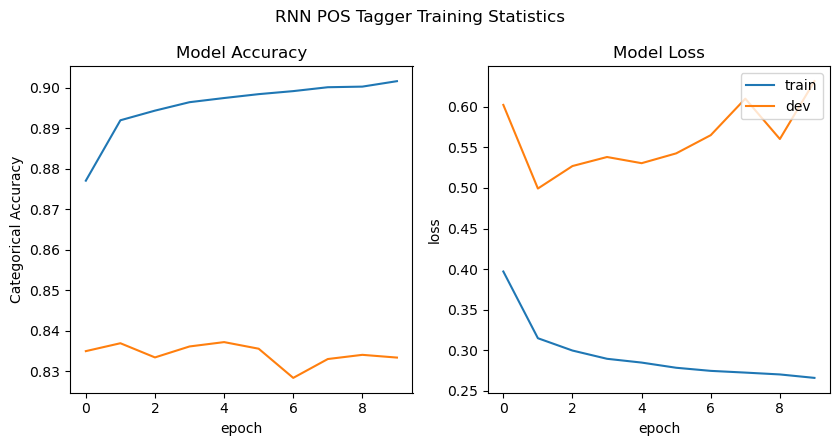

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Categorical Accuracy')
ax1.set_xlabel('epoch')

# summarize history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')

fig.suptitle("RNN POS Tagger Training Statistics")
fig.set_size_inches(8.5, 4.5)

plt.legend(['train', 'dev'], loc='upper right')
plt.tight_layout()

util.save_plot("ex_2_fit.png", OUTPUT_DIR)
plt.show()

In [59]:
base_res_df = util.stats_all_splits(base_cls,
                             lambda x: np.array(x),
                             x_base_train,
                             x_base_valid,
                             x_base_test,
                             y_base_train,
                             y_base_valid,
                             y_base_test)
base_res_df["model"] = "Baseline"

In [60]:
mlp_res_df = util.stats_all_splits(mlp,
                             lambda x: lb_mlp.inverse_transform(x),
                             x_train_mlp,
                             x_valid_mlp,
                             x_test_mlp, 
                             y_train_mlp, 
                             y_valid_mlp, 
                             y_test_mlp)
mlp_res_df["model"] = "MLP"

313/313 [==============================] - 1s 3ms/step


In [61]:
rnn_res_df = util.stats_all_splits(model,
                             lambda x: lb.inverse_transform(x),
                             train_data,
                             val_data,
                             test_data, 
                             y_train, 
                             y_valid, 
                             y_test)
rnn_res_df["model"] = "RNN"

785/785 [==============================] - 37s 47ms/step


In [64]:
final_df = pd.concat([base_res_df, mlp_res_df, rnn_res_df])

final_train_df = final_df[final_df.split == "training"]
final_valid_df = final_df[final_df.split == "validation"]
final_test_df = final_df[final_df.split == "test"]

final_train_df = final_train_df.drop("split", axis=1)
final_valid_df = final_valid_df.drop("split", axis=1)
final_test_df = final_test_df.drop("split", axis=1)

final_train_df = final_train_df.pivot(
    index="tag", columns="model", values=["precision", "recall", "f1"]
)

final_valid_df = final_valid_df.pivot(
    index="tag", columns="model", values=["precision", "recall", "f1"]
)

final_test_df = final_test_df.pivot(
    index="tag", columns="model", values=["precision", "recall", "f1"]
)

In [65]:
final_train_df

precision                        recall                            f1  \
model  Baseline       MLP       RNN  Baseline       MLP       RNN  Baseline   
tag                                                                           
ADJ    1.000000  1.000000  1.000000  0.892944  0.927057  0.899407  0.943445   
ADP    1.000000  1.000000  1.000000  0.665187  0.909570  0.862939  0.798934   
ADV    1.000000  1.000000  1.000000  0.829625  0.856354  0.836250  0.906880   
AUX    1.000000  1.000000  1.000000  0.785080  0.968977  0.950265  0.879602   
CCONJ  1.000000  1.000000  1.000000  0.992673  0.993998  0.971292  0.996323   
DET    1.000000  1.000000  1.000000  0.950795  0.973863  0.981349  0.974777   
INTJ   1.000000  1.000000  1.000000  0.865801  0.855072  0.858586  0.928074   
MACRO  0.850334  0.905588  0.857097  0.835269  0.879980  0.827447  0.836866   
NOUN   1.000000  1.000000  1.000000  0.896102  0.940246  0.943872  0.945204   
NUM    1.000000  1.000000  1.000000  0.889966  0.965377  0.975521  0.941780   
PART   1.000000  1.000000  1.000000  0.885525  0.953717  0.992519  0.939288   
PRON   1.000000  1.000000  1.000000  0.949737  0.967000  0.876676  0.974221   
PROPN  1.000000  1.000000  1.000000  0.839270  0.830579  0.863286  0.912612   
PUNCT  1.000000  1.000000  1.000000  0.988431  0.995726  0.998983  0.994182   
SCONJ  1.000000  1.000000  1.000000  0.414952  0.699095  0.614222  0.586524   
SYM    1.000000  1.000000  1.000000  0.826630  0.850575  0.018031  0.905087   
VERB   1.000000  1.000000  1.000000  0.887227  0.893144  0.818093  0.940244   
X      1.000000  1.000000  1.000000  0.639626  0.379310  0.605304  0.780209   

                           
model       MLP       RNN  
tag                        
ADJ    0.962148  0.947040  
ADP    0.952644  0.926428  
ADV    0.922619  0.910824  
AUX    0.984244  0.974498  
CCONJ  0.996990  0.985437  
DET    0.986758  0.990586  
INTJ   0.921875  0.923913  
MACRO  0.889973  0.823709  
NOUN   0.969203  0.971125  
NUM    0.982383  0.987609  
PART   0.976310  0.996246  
PRON   0.983223  0.934286  
PROPN  0.907449  0.926627  
PUNCT  0.997859  0.999491  
SCONJ  0.822903  0.761013  
SYM    0.919255  0.035422  
VERB   0.943556  0.899946  
X      0.550000  0.754130

In [66]:
def export_to_latex(df: pd.DataFrame, name:str, col_format:str, caption=None):
    """
    Export a pandas DataFrame to a LaTeX file.

    :param df: The DataFrame to be exported.
    :type df: pd.DataFrame

    :param name: The name of the LaTeX file (excluding the '.tex' extension).
    :type name: str

    :param col_format: A string specifying the column formatting for the LaTeX table.
    :type col_format: str

    :param caption: The caption for the LaTeX table (optional).
    :type caption: str, optional

    :return: This function does not return anything.
    """
    path = os.path.join(OUTPUT_DIR, name)
    df.to_latex(buf=path,
                index=True,
                formatters={"name": str.upper},
                float_format="{:.3f}".format,
                label="tab::" + name.split(".")[0],
                caption=caption,
                escape=True,
                bold_rows= True,
               encoding="utf-8",
               column_format=col_format)
    print(f"Dataframe exported to {path}")

long_col_format = '|l|l|l|l|l|l|'

In [67]:
export_to_latex(final_train_df, 
                "ex_2_train.tex", 
                long_col_format,
                "Results on the training dataset.")

export_to_latex(final_valid_df, 
                "ex_2_valid.tex", 
                long_col_format,
                "Results on the validation dataset.")

export_to_latex(final_test_df, 
                "ex_2_test.tex", 
                long_col_format,
                "Results on the test dataset.")

Dataframe exported to output/ex_2_train.tex
Dataframe exported to output/ex_2_valid.tex
Dataframe exported to output/ex_2_test.tex
